In [61]:
import numpy as np 
import matplotlib.pyplot as plt 

import string
import random 
import re 
import requests 
import os 
import textwrap

In [62]:
# create substitution cipher 
# one will act as the key, other as the value 
letters1 = list(string.ascii_lowercase) 
letters2 = list(string.ascii_lowercase) 

true_mappings = {}

# suffle second set of letters
random.shuffle(letters2) 

# populate map, true_mapping is only accessible to sender and receiver
for k, v in zip(letters1, letters2): 
    true_mappings[k] = v 

In [63]:
# the language model 
# initialize Markov matrix 
M = np.ones((26, 26))

# initial state distribution 
pi = np.zeros(26) 

# a function to update the Markov matrix 
def update_transition(ch1, ch2): 
    # ord('a') = 97, ord('b') = 98, ascii encodings
    i = ord(ch1) - 97
    j = ord(ch2) - 97
    M[i, j] += 1

# function to update the initial state distribution 
def update_pi(ch): 
    i = ord(ch) - 97 
    pi[i] += 1 

# get the log-probability of a word
def get_word_prob(word): 
    # first letter
    i = ord(word[0]) - 97

    # get probability of the first letter
    logp = np.log(pi[i])

    # get probabilities of bigrams 
    for ch in word[1:]: 
        j = ord(ch) - 97
        logp += np.log(M[i, j]) # update prob

        # for next inter, increment current last word pointer to current word
        # because the probability only depends on the last word
        i = j
    
    return logp 

# get probability of sentence 
def get_sequence_prob(words): 
    # if iinput is a string, split into an array of tokens 
    if type(words) == str: 
        words = words.split() 

    logp = 0 
    for word in words: 
        logp += get_word_prob(word) 

    return logp 

In [64]:
# create a markov model based on an English dataset 

# download the file 
if not os.path.exists("./data/moby_dick.txt"): 
    print("Downloading moby dick...")
    r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
    with open("./data/moby_dick.txt", "w") as f: 
        f.write(r.content.decode()) 

In [65]:
# for replacing non-alpha characters
regex = re.compile("[^a-zA-Z]")

# load in words 
for line in open("./data/moby_dick.txt"): 
    line = line.rstrip() 

    # there are blank lines in the file 
    if line: 
        # replace all non-alpha chars with space 
        line = regex.sub(' ', line)

        # split the tokens in the line and lowercase 
        tokens = line.lower().split() 

        for token in tokens: 
            # update the model 
            # first letter
            ch0 = token[0]
            update_pi(ch0) 

            # other letters 
            for ch1 in token[1:]: 
                update_transition(ch0, ch1) 
                ch0 = ch1
            
# normalize the probabilities, since now they are counts 
pi /= pi.sum() 
M  /= M.sum(axis=1, keepdims=True)


In [66]:
# letters from a to z
pi[:10]

array([0.10945403, 0.05200697, 0.03898427, 0.02712131, 0.01824855,
       0.03850453, 0.01632961, 0.06393979, 0.06720943, 0.00390774])

In [97]:
# encode a message

# random excerpt from adventures of sherlock holmes
original_message = '''Alice woke up early on a beautiful Sunday morning, feeling refreshed and full of energy. She decided to take a walk in the nearby park and enjoy the fresh air and sunshine. As she strolled along the path, she saw a group of children playing frisbee and laughing together. She couldn't help but smile at their carefree joy.

Further down the path, she encountered an old couple sitting on a bench, holding hands and looking out at the lake. They had been married for over sixty years and were still deeply in love. Alice felt a warm feeling of happiness in her heart, knowing that true love could last a lifetime.

As she continued her walk, Alice came across a group of volunteers cleaning up the park. They were picking up litter, planting flowers, and generally making the park a better place for everyone to enjoy. Alice was inspired by their dedication and decided to join in, lending a hand to make a positive impact on her community.

After a few hours of volunteering, Alice headed back home, feeling tired but fulfilled. She spent the rest of the day relaxing with a good book and reflecting on the simple joys of life. She realized that happiness could be found in the small things, like a walk in the park, the laughter of children, and the kindness of strangers.




'''

In [98]:
def encode_message(msg): 
    msg = msg.lower() 

    # replace non-alpha characters
    msg = regex.sub(' ', msg) 

    # make the encoded message 
    coded_msg = [] 
    for ch in msg: 
        # may be a whitespace (not encoded)
        coded_ch = ch 

        # encode if its in the cipher
        if ch in true_mappings: 
            coded_ch = true_mappings[ch]
            
        coded_msg.append(coded_ch) 
    
    return ''.join(coded_msg) 

In [99]:
encoded_message = encode_message(original_message) 
encoded_message

'augfp evtp on paduk vh a qpaoigcou sohmak yvdhghw  cppughw dpcdpszpm ahm couu vc phpdwk  szp mpfgmpm iv iatp a eaut gh izp hpadqk nadt ahm phbvk izp cdpsz agd ahm sohszghp  as szp sidvuupm auvhw izp naiz  szp sae a wdvon vc fzgumdph nuakghw cdgsqpp ahm uaowzghw ivwpizpd  szp fvoumh i zpun qoi sygup ai izpgd fadpcdpp bvk   codizpd mveh izp naiz  szp phfvohipdpm ah vum fvonup sgiighw vh a qphfz  zvumghw zahms ahm uvvtghw voi ai izp uatp  izpk zam qpph yaddgpm cvd vrpd sgxik kpads ahm epdp siguu mppnuk gh uvrp  augfp cpui a eady cppughw vc zannghpss gh zpd zpadi  thveghw izai idop uvrp fvoum uasi a ugcpigyp   as szp fvhighopm zpd eaut  augfp fayp afdvss a wdvon vc rvuohippds fupahghw on izp nadt  izpk epdp ngftghw on ugiipd  nuahighw cuvepds  ahm wphpdauuk yatghw izp nadt a qpiipd nuafp cvd prpdkvhp iv phbvk  augfp eas ghsngdpm qk izpgd mpmgfaigvh ahm mpfgmpm iv bvgh gh  uphmghw a zahm iv yatp a nvsgigrp gynafi vh zpd fvyyohgik   acipd a cpe zvods vc rvuohippdghw  augfp zpampm qaft zvyp 

In [100]:
def decode_message(msg, word_map): 
    decoded_msg = [] 
    for ch in msg: 
        decoded_ch = ch 
        if ch in word_map: 
            decoded_ch = word_map[ch]
        decoded_msg.append(decoded_ch) 
    return ''.join(decoded_msg)

In [101]:
# run an evolutionary algorith to decode the message

dna_pool = []
for _ in range(20): 
    dna = list(string.ascii_lowercase) 
    random.shuffle(dna) 
    dna_pool.append(dna) 

In [102]:
def evolve_offspring(dna_pool, n_children): 
    # make n_children per offspring 
    offspring = []

    for dna in dna_pool: 
        for _ in range(n_children): 
            # copy the whole letter sequence
            copy = dna.copy()

            j = np.random.randint(len(copy))
            k = np.random.randint(len(copy))

            # switch 2 chars
            tmp = copy[j]
            copy[j] = copy[k]
            copy[k] = tmp 
            offspring.append(copy)
    
    # final population 
    return offspring + dna_pool

In [103]:
num_iters = 1000
scores = np.zeros(num_iters) 
best_dna = None
best_map = None
best_score = float('-inf')

for i in range(num_iters): 
    if i > 0: 
        # get offspring from the current dna pool 
        dna_pool = evolve_offspring(dna_pool, 3) 
    
    # calculate score for each dna 
    dna2score = {}
    for dna in dna_pool: 
        # populate map 
        current_map = {}
        for k, v in zip(letters1, dna): 
            current_map[k] = v 
        
        decoded_message = decode_message(encoded_message, current_map) 
        score = get_sequence_prob(decoded_message) 

        # store it 
        # needs to be a string to be a dict key 
        dna2score[''.join(dna)] = score

        # record the best so far 
        if score > best_score: 
            best_dna = dna
            best_map = current_map
            best_score = score
    
    # average score for this generation 
    scores[i] = np.mean(list(dna2score.values()))

    # keep the best 5 dna
    # also turn them back into list of single chars
    sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse = True)

    # keep top 5 best dna sequences
    dna_pool = [list(k) for k, v in sorted_dna[:5]]

    if i % 200 == 0: 
        print('iter: ', i, " score: ", scores[i], " best so far: ", best_score)


iter:  0  score:  -5476.108263592851  best so far:  -4655.642759559595
iter:  200  score:  -2734.459388901364  best so far:  -2492.198153645499
iter:  400  score:  -2688.7512392276535  best so far:  -2412.031782268528
iter:  600  score:  -2679.2210451714163  best so far:  -2412.031782268528
iter:  800  score:  -2683.081620505977  best so far:  -2412.031782268528


In [104]:
# use best score 
decoded_message = decode_message(encoded_message, best_map) 

print("Log Likelyhood of decoded message:", get_sequence_prob(decoded_message))
print("Log Likelyhood of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))

# which letters are wrong?
for true, v in true_mappings.items(): 
    pred = best_map[v] 
    if true != pred: 
        print("true: %s, pred: %s" % (true, pred))

Log Likelyhood of decoded message: -2412.031782268528
Log Likelyhood of true message: -2412.031782268528


In [105]:
# print the final decoded message 
print("Decoded message \n", decoded_message)

Decoded message 
 alice woke up early on a beautiful sunday morning  feeling refreshed and full of energy  she decided to take a walk in the nearby park and enjoy the fresh air and sunshine  as she strolled along the path  she saw a group of children playing frisbee and laughing together  she couldn t help but smile at their carefree joy   further down the path  she encountered an old couple sitting on a bench  holding hands and looking out at the lake  they had been married for over sixty years and were still deeply in love  alice felt a warm feeling of happiness in her heart  knowing that true love could last a lifetime   as she continued her walk  alice came across a group of volunteers cleaning up the park  they were picking up litter  planting flowers  and generally making the park a better place for everyone to enjoy  alice was inspired by their dedication and decided to join in  lending a hand to make a positive impact on her community   after a few hours of volunteering  alice 

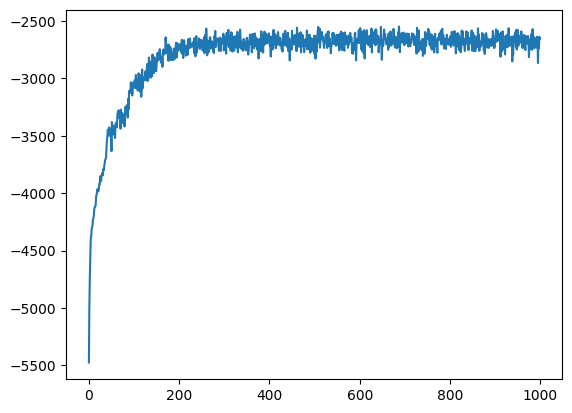

In [106]:
plt.plot(scores) 
plt.show() 